# Setup

Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks
: https://arxiv.org/abs/1703.10593

In [ ]:
!pip install -q lightning
!pip install -q datasets

# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import lightning as L
from tqdm.auto import tqdm

from einops.layers.torch import Reduce, Rearrange
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
L.seed_everything(42)

torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

torch.autograd.set_detect_anomaly(True)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data

In [ ]:
import random
from torch.utils.data import Dataset

class CombinedDataset(Dataset):
    def __init__(self, dataset_a, dataset_b):
        self.dataset_a = dataset_a
        self.dataset_b = dataset_b
        self.indices_a = list(range(len(dataset_a)))
        self.indices_b = list(range(len(dataset_b)))

    def __len__(self):
        return min(len(self.dataset_a), len(self.dataset_b))

    def __getitem__(self, idx):
        if idx==0:
            random.shuffle(self.indices_a)
            random.shuffle(self.indices_b)

        sample_a = self.dataset_a[self.indices_a[idx]]['image']
        sample_b = self.dataset_b[self.indices_b[idx]]['image']

        return sample_a, sample_b

In [ ]:
from datasets import load_dataset
from torchvision import transforms

class DataModule(L.LightningDataModule):
    def __init__(self, batch_size=32, size=256, target_size=256):
        super().__init__()
        self.batch_size=batch_size
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomCrop(target_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    def prepare_data(self):
        load_dataset('gigant/horse2zebra','horse')
        load_dataset('gigant/horse2zebra','zebra')

    def setup(self, stage=None):
        self.horse=load_dataset('gigant/horse2zebra','horse')
        tmp=self.horse['train'].train_test_split(train_size=0.8, seed=42)
        self.horse['validation']=tmp.pop('test')

        self.zebra=load_dataset('gigant/horse2zebra','zebra')
        tmp=self.zebra['train'].train_test_split(train_size=0.8, seed=42)
        self.zebra['validation']=tmp.pop('test')

    def collator(self, batch):
        horse=torch.stack([self.transform(x[0]) for x in batch], dim=0)
        zebra=torch.stack([self.transform(x[1]) for x in batch], dim=0)

        return horse, zebra

    def train_dataloader(self):
        return DataLoader(CombinedDataset(self.horse['train'], self.zebra['train']),
                          batch_size=self.batch_size, collate_fn=self.collator, shuffle=False, drop_last=True)

    def val_dataloader(self):
        return DataLoader(CombinedDataset(self.horse['validation'], self.zebra['validation']),
                          batch_size=self.batch_size, collate_fn=self.collator, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(CombinedDataset(self.horse['test'], self.zebra['test']),
                          batch_size=self.batch_size, collate_fn=self.collator, shuffle=False, drop_last=True)

tmp=DataModule()
tmp.prepare_data()
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


2
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])


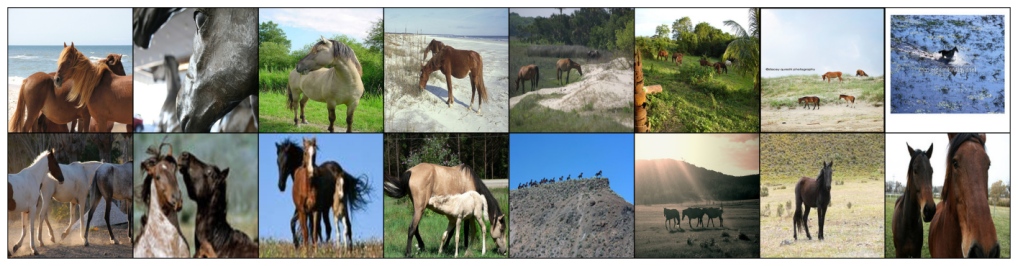

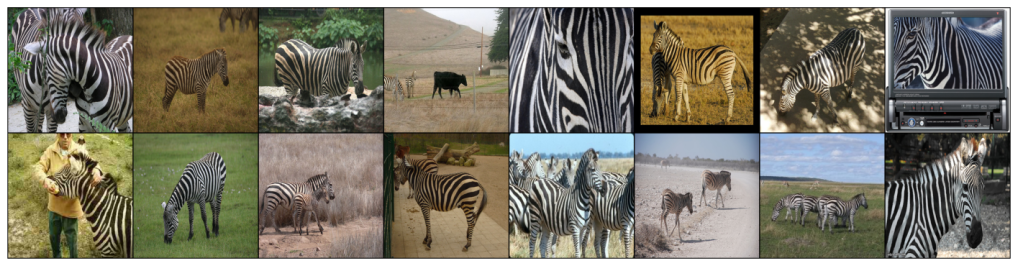

In [ ]:
from torchvision.utils import make_grid

def show_images(images, num_images=16):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.figure(figsize=(18,18))
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_images(batch[0])
show_images(batch[1])

# Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x+ self.net(x)

x=torch.rand(7,3,32,32)
tmp=ResidualBlock(3)
tmp(x).shape

torch.Size([7, 3, 32, 32])

In [ ]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, use_norm=True, act_fn='relu'):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(in_channels, in_channels*2, kernel_size, padding=1, stride=2, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels*2) if use_norm else nn.Identity(),
            nn.ReLU(inplace=True) if act_fn=='relu' else nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.net(x)

x=torch.rand(7,3,32,32)
tmp=ContractingBlock(3)
tmp(x).shape

torch.Size([7, 6, 16, 16])

In [ ]:
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, use_norm=True):
        super().__init__()
        self.net=nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(in_channels//2) if use_norm else nn.Identity(),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

x=torch.rand(7,3,32,32)
tmp=ExpandingBlock(3)
tmp(x).shape

torch.Size([7, 1, 64, 64])

In [ ]:
class FeatureMapBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv=nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')

    def forward(self, x):
        return self.conv(x)

x=torch.rand(7,3,32,32)
tmp=FeatureMapBlock(3,6)
tmp(x).shape

torch.Size([7, 6, 32, 32])

In [ ]:
class Generator(nn.Module):
    def __init__(self,in_channels, out_channels, hidden_channels, factor=4):
        super().__init__()
        self.up_sample=FeatureMapBlock(in_channels, hidden_channels)
        self.contract=nn.Sequential(
            ContractingBlock(hidden_channels),
            ContractingBlock(hidden_channels*2)
        )
        self.res=nn.Sequential(
            *[ResidualBlock(hidden_channels * factor) for _ in range(9)]
        )
        self.expand=nn.Sequential(
            ExpandingBlock(hidden_channels*4),
            ExpandingBlock(hidden_channels*2)
        )
        self.down_sample = FeatureMapBlock(hidden_channels, out_channels)

    def forward(self, x):
        x=self.up_sample(x)
        x=self.contract(x)
        x=self.res(x)
        x=self.expand(x)
        x=self.down_sample(x)

        return F.tanh(x)

x=torch.rand(7,3,32,32)
tmp=Generator(3,1,3)
tmp(x).shape

torch.Size([7, 1, 32, 32])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        self.net=nn.Sequential(
            FeatureMapBlock(in_channels, hidden_channels),
            ContractingBlock(hidden_channels, kernel_size=4, use_norm=False, act_fn='leaky_relu'),
            ContractingBlock(hidden_channels * 2, kernel_size=4, act_fn='leaky_relu'),
            ContractingBlock(hidden_channels * 4, kernel_size=4, act_fn='leaky_relu'),
            nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.net(x)

x=torch.rand(7,3,256,256)
tmp=Discriminator(3)
tmp(x).shape

torch.Size([7, 1, 32, 32])

# Traininig

In [ ]:
lr=1e-3
batch_size=1

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

data_module=DataModule(batch_size=batch_size)
data_module.setup()
train_loader=data_module.train_dataloader()

gen_AB=Generator(3,3,4).to(device)
gen_BA=Generator(3,3,4).to(device)
gen_opt=torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))

disc_A=Discriminator(3).to(device)
disc_A_opt=torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B=Discriminator(3).to(device)
disc_B_opt=torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def get_acc(pred,mode=0):
    pred = torch.sigmoid(pred)
    if mode==0:
        target=torch.zeros_like(pred)
        acc= ((pred<0.5)==target).float().mean()
    else:
        target=torch.ones_like(pred)
        acc= ((pred>=0.5)==target).float().mean()

    return acc.item()

In [ ]:
num_epochs = 10
lambda_identity = 0.1
lambda_cycle = 10

for epoch in tqdm(range(num_epochs)):
    p_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}: ')

    for batch in p_bar:
        real_A = batch[0].to(device)
        real_B = batch[1].to(device)

        # -------------------------------
        # Train Discriminator A
        # -------------------------------
        disc_A_opt.zero_grad()
        fake_A = gen_BA(real_B)

        # Fake predictions
        fake_pred = disc_A(fake_A.detach())
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred, device=device))

        # Real predictions
        real_pred = disc_A(real_A)
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred, device=device))

        # Total loss for discriminator A
        disc_A_loss = (fake_loss + real_loss) / 2
        disc_A_loss.backward()
        disc_A_opt.step()

        # Discriminator A accuracy
        disc_A_fake_acc = get_acc(fake_pred, 0)
        disc_A_real_acc = get_acc(real_pred, 1)
        disc_A_acc = (disc_A_fake_acc + disc_A_real_acc) / 2

        # -------------------------------
        # Train Discriminator B
        # -------------------------------
        disc_B_opt.zero_grad()
        fake_B = gen_AB(real_A)

        # Fake predictions
        fake_pred = disc_B(fake_B.detach())
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred, device=device))

        # Real predictions
        real_pred = disc_B(real_B)
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred, device=device))

        # Total loss for discriminator B
        disc_B_loss = (fake_loss + real_loss) / 2
        disc_B_loss.backward()
        disc_B_opt.step()

        # Discriminator B accuracy
        disc_B_fake_acc = get_acc(fake_pred, 0)
        disc_B_real_acc = get_acc(real_pred, 1)
        disc_B_acc = (disc_B_fake_acc + disc_B_real_acc) / 2

        # -------------------------------
        # Train Generators AB and BA
        # -------------------------------
        gen_opt.zero_grad()

        fake_B = gen_AB(real_A)
        fake_B_pred = disc_B(fake_B.detach())
        gen_AB_loss = F.binary_cross_entropy_with_logits(fake_B_pred, torch.ones_like(fake_B_pred, device=device))

        fake_A = gen_BA(real_B)
        fake_A_pred = disc_A(fake_A.detach())
        gen_BA_loss = F.binary_cross_entropy_with_logits(fake_A_pred, torch.ones_like(fake_A_pred, device=device))

        adv_loss = gen_AB_loss + gen_BA_loss

        # Identity loss
        identity_A = gen_BA(real_A)
        identity_loss_A = F.l1_loss(identity_A, real_A)

        identity_B = gen_AB(real_B)
        identity_loss_B = F.l1_loss(identity_B, real_B)

        identity_loss = identity_loss_A + identity_loss_B

        # Cycle loss
        cycle_B = gen_AB(fake_A)
        cycle_loss_AB = F.l1_loss(cycle_B, real_B)

        cycle_A = gen_BA(fake_B)
        cycle_loss_BA = F.l1_loss(cycle_A, real_A)

        cycle_loss = cycle_loss_AB + cycle_loss_BA

        # Total generator loss
        gen_loss = adv_loss + lambda_identity * identity_loss + lambda_cycle * cycle_loss
        gen_loss.backward()
        gen_opt.step()

        p_bar.set_postfix(gen_loss=gen_loss.item(),
                          gen_AB_acc=get_acc(fake_B_pred, 1),
                          gen_BA_acc=get_acc(fake_A_pred, 1),
                          disc_A_acc=disc_A_acc,
                          disc_B_acc=disc_B_acc)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/1067 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Lightning

In [ ]:
class CycleGAN(L.LightningModule):
    def __init__(self, img_channels, hidden_channels, lambda_identity = 0.1, lambda_cycle = 10, lr=1e-3, beta_1=0.5, beta_2=0.999):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization=False

        self.gen_AB=Generator(img_channels, img_channels, hidden_channels)
        self.gen_BA=Generator(img_channels ,img_channels, hidden_channels)
        self.disc_A=Discriminator(img_channels)
        self.disc_B=Discriminator(img_channels)

    def forward(self, real_A):
        fake_B = self.gen_AB(real_A)
        fake_A = self.gen_BA(fake_B)
        return fake_B, fake_A

    def training_step(self, batch):
        real_A = batch[0]
        real_B = batch[1]

        gen_opt, disc_A_opt, disc_B_opt=self.optimizers()

        # -------------------------------
        # Train Discriminator A
        # -------------------------------
        self.toggle_optimizer(disc_A_opt)
        disc_A_opt.zero_grad()

        fake_A = self.gen_BA(real_B).detach()
        fake_pred = self.disc_A(fake_A)
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred, device=self.device))

        real_pred = self.disc_A(real_A)
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred, device=self.device))

        disc_A_loss = (fake_loss + real_loss) / 2
        self.manual_backward(disc_A_loss)
        disc_A_opt.step()

        disc_A_fake_acc = self.get_acc(fake_pred, 0)
        disc_A_real_acc = self.get_acc(real_pred, 1)
        disc_A_acc = (disc_A_fake_acc + disc_A_real_acc) / 2

        self.untoggle_optimizer(disc_A_opt)
        # -------------------------------
        # Train Discriminator B
        self.toggle_optimizer(disc_B_opt)
        disc_B_opt.zero_grad()

        fake_B = self.gen_AB(real_A)
        fake_pred = self.disc_B(fake_B.detach())
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred, device=self.device))

        real_pred = self.disc_B(real_B)
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred, device=self.device))

        disc_B_loss = (fake_loss + real_loss) / 2
        self.manual_backward(disc_B_loss)
        disc_B_opt.step()

        disc_B_fake_acc = self.get_acc(fake_pred, 0)
        disc_B_real_acc = self.get_acc(real_pred, 1)
        disc_B_acc = (disc_B_fake_acc + disc_B_real_acc) / 2
        self.untoggle_optimizer(disc_B_opt)

        # -------------------------------
        # Train Generators AB and BA
        self.toggle_optimizer(gen_opt)
        gen_opt.zero_grad()

        # Generator Adversarial loss)
        fake_B = self.gen_AB(real_A).detach()
        fake_B_pred = self.disc_B(fake_B)
        gen_AB_loss = F.binary_cross_entropy_with_logits(fake_B_pred, torch.ones_like(fake_B_pred, device=self.device))

        fake_A = self.gen_BA(real_B).detach()
        fake_A_pred = self.disc_A(fake_A)
        gen_BA_loss = F.binary_cross_entropy_with_logits(fake_A_pred, torch.ones_like(fake_A_pred, device=self.device))

        adv_loss = gen_AB_loss + gen_BA_loss

        # Identity loss
        identity_A = self.gen_BA(real_A)
        identity_loss_A = F.l1_loss(identity_A, real_A)

        identity_B = self.gen_AB(real_B)
        identity_loss_B = F.l1_loss(identity_B, real_B)

        identity_loss = identity_loss_A + identity_loss_B

        # Cycle loss
        cycle_B = self.gen_AB(fake_A)
        cycle_loss_AB = F.l1_loss(cycle_B, real_B)

        cycle_A = self.gen_BA(fake_B)
        cycle_loss_BA = F.l1_loss(cycle_A, real_A)

        cycle_loss = cycle_loss_AB + cycle_loss_BA

        # Total generator loss
        gen_loss = adv_loss + self.hparams.lambda_identity * identity_loss + self.hparams.lambda_cycle * cycle_loss
        self.manual_backward(gen_loss)
        gen_opt.step()
        self.untoggle_optimizer(gen_opt)

        self.log("gen_loss", gen_loss.item(), prog_bar=True)
        self.log("gen_AB_acc", self.get_acc(fake_B_pred, 1), prog_bar=True)
        self.log("gen_BA_acc", self.get_acc(fake_A_pred, 1), prog_bar=True)
        self.log("disc_A_acc", disc_A_acc, prog_bar=True)
        self.log("disc_B_acc", disc_B_acc, prog_bar=True)

    def configure_optimizers(self):
        gen_opt=torch.optim.Adam(list(self.gen_AB.parameters()) + list(self.gen_BA.parameters()), lr=self.hparams.lr, betas=(self.hparams.beta_1, self.hparams.beta_2))
        disc_B_opt=torch.optim.Adam(self.disc_B.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta_1, self.hparams.beta_2))
        disc_A_opt=torch.optim.Adam(self.disc_A.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta_1, self.hparams.beta_2))

        return [gen_opt, disc_A_opt, disc_B_opt], []

    def get_acc(self, pred,mode=0):
        pred = torch.sigmoid(pred)
        if mode==0:
            target=torch.zeros_like(pred)
            acc= ((pred<0.5)==target).float().mean()
        else:
            target=torch.ones_like(pred)
            acc= ((pred>=0.5)==target).float().mean()

        return acc.item()

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

batch_size=2
data_module=DataModule(batch_size)
model=CycleGAN(img_channels=3, hidden_channels=2, lambda_identity = 0.1, lambda_cycle = 10, lr=1e-3, beta_1=0.5, beta_2=0.999)
trainer=L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=5,
    deterministic=True
)
trainer.fit(model, data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name   | Type          | Params | Mode 
-------------------------------------------------
0 | gen_AB | Generator     | 11.8 K | train
1 | gen_BA | Generator     | 11.8 K | train
2 | disc_A | Discriminator | 2.8 M  | train
3 | disc_B | Discriminator | 2.8 M  | train
-------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.202    Total estimated model params size (MB)
222       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type          | Params | Mode 
-------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined